# Логистическая регрессия в `sklearn` и метрики качества классификации

In [ ]:
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix
)

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='dark', font_scale=1.7)

## Логистическая регрессия

### [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)


* Наиболее важные параметры:
    * `penalty` &mdash; задает норму регуляризатора, возможные варианты: `{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}`, по-умолчанию `’l2’`;
    * `C` &mdash; константа, обратная к константе перед регуляризацией, т.е. меньшие значения указывают на более сильную регуляризацию, по-умолчанию $1.0$;
    * `fit_intercept` &mdash; указывает, следует ли добавить константу к исходным признакам, по-умолчанию `True`;
    * `multi_class` &mdash; стратегия при мультиклассовой классификации, возможные варианты: `{‘auto’, ‘ovr’, ‘multinomial’}` по-умолчанию `’auto’`;
    * `solver` &mdash; метод оптимизации, возможные варианты: `{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}`, по-умолчанию `'lbfgs'`.
* Наиболее важные аттрибуты:
    * `coef_` &mdash; оценки коэффициентов логистической регрессии;
    * `intercept_` &mdash; оценка коэффициента перед единичным признаком;
* Методы:
    * `fit()` &mdash; обучение классификатора;
    * `predict()` &mdash; предсказание метки класса;
    * `predict_proba()` &mdash; предсказание вероятностей классов;
    * `predict_log_proba()` &mdash; предсказание логарифмов вероятностей классов;
    * `decision_function()` &mdash; значения перед применением логит-функции, характеризуют степень уверенности модели в предсказании.

### Данные

В качестве примера рассмотрим данные для бинарной классификации с двумя признаками. Классы несбалансированны и линейно не разделимы.

In [ ]:
X, y = make_blobs(n_samples=(500, 50), centers=[[2, 2], [-2, -2]], 
                  cluster_std=2.5, random_state=42)

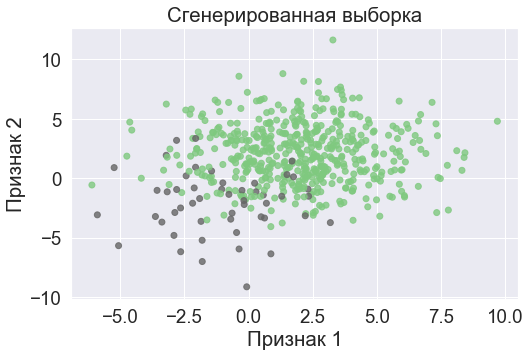

In [ ]:
plt.figure(figsize=(8, 5))
plt.title('Сгенерированная выборка')
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, cmap='Accent')
plt.grid()
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.show()

Разделим данные на обучающую и тестовую выборку:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

Выведем размерности выборок:

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((467, 2), (83, 2), (467,), (83,))

### Модель

Определим модель логистической регресии и обучим ее:

In [ ]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Выведем коэффициенты модели:

In [ ]:
clf.coef_

array([[-0.55679722, -0.80368722]])

Выведем коэффициент перед свободным параметром:

In [ ]:
clf.intercept_

array([-2.11685474])

### Результат

График предсказаний вероятности принадлежности классу:

In [ ]:
x0_grid, x1_grid = np.meshgrid(np.linspace(-10, 10, 2001), 
                               np.linspace(-10, 10, 2001))
ravel_grid = np.array([x0_grid, x1_grid]).reshape((2, 2001*2001)).T
prob_grid = clf.predict_proba(ravel_grid)
prob_grid = prob_grid[:, 0].reshape((2001, 2001))

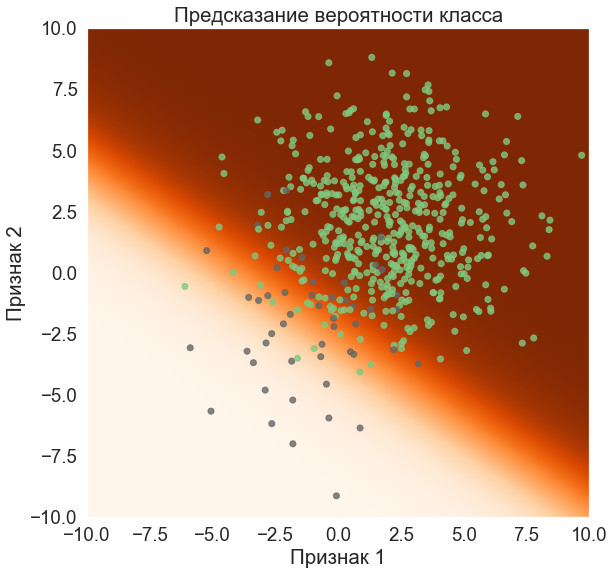

In [ ]:
plt.figure(figsize=(9, 9))
plt.pcolormesh(x0_grid, x1_grid, prob_grid, cmap='Oranges')
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, cmap='Accent')
plt.xlim((-10, 10))
plt.ylim((-10, 10))
plt.xlabel('Признак 1'), plt.ylabel('Признак 2')
plt.title('Предсказание вероятности класса');

## Метрики качества классификации

Для бинарной классификации существует множество различных метрик качества. В этом ноутбуке рассмотрим самые основные.

### Accuracy (доля правильных ответов)

[Accuracy в `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

Данная метрика является самой тривиальной метрикой для задачи классификации и представляет собой долю правильных ответов:

$$accuracy(y, \widehat{y}) = \frac{1}{n}\sum\limits_{i=1}^{n} {I\{y_i = \widehat{y}_i\}},$$   
  
где $y$ &mdash; вектор истинных классов, $\widehat{y}$ &mdash; вектор предсказанных классов, $n$ &mdash; количество объектов.

**Достоинство**: в основе метрики $accuracy$ лежит простая интуиция.

**Недостаток**: данная метрика плоха в случае дисбаланса классов, когда представителей одного из класса существенно больше, чем другого.

Рассмотрим пример выборки, в которой $950$ положительных и $50$ отрицательных объектов. Пусть наш классификатор всем объектам выдает класс $1$. Тогда его accuracy будет равен $0.95$, что является очень неплохим результатом. Однако сама модель при этом не имеет особого смысла: она просто возвращает константу при любом входе.

Это означает, что доля правильных ответов сама по себе не несет никакой информации о качестве работы модели, и вместе с ней следует анализировать соотношение классов в выборке.

**Пример вычисления**

Вычислим $accuracy$ для нашей задачи:

In [ ]:
accuracy = accuracy_score(y_test, clf.predict(X_test))
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.904


В данной ситуации эта метрика не очень информативна, так как классификатор, предсказывающий всегда 1 класс, имел бы accuracy $\approx 90\%$ 

## Случай линейно разделимых классов

Теперь рассмотрим случай, когда классы линейно разделимы:

In [ ]:
X, y = make_blobs(n_samples=(500, 50), random_state=42)

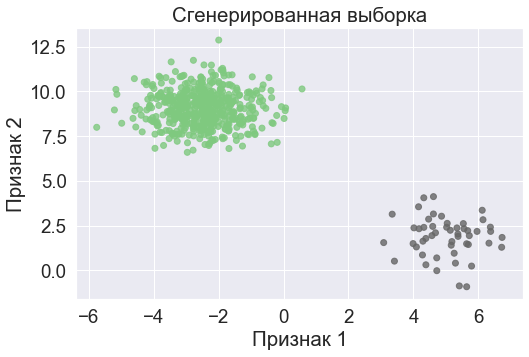

In [ ]:
plt.figure(figsize=(8, 5))
plt.title('Сгенерированная выборка')
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, cmap='Accent')
plt.grid()
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.show()

Разделим данные на обучающую и тестовую выборку:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

Выведем размерности выборок:

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((467, 2), (83, 2), (467,), (83,))

Обучим модель:

In [ ]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

И посмотрим на метрики:

In [ ]:
predicted = clf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
precision = precision_score(y_test, predicted)
recall = recall_score(y_test, predicted)
f1 = f1_score(y_test, predicted)
print(f'Accuracy = {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 = {f1:.3f}')

Accuracy = 1.000
Precision: 1.000
Recall: 1.000
F1 = 1.000


In [ ]:
x0_grid, x1_grid = np.meshgrid(np.linspace(-10, 10, 2001), 
                               np.linspace(-2, 12, 2001))
ravel_grid = np.array([x0_grid, x1_grid]).reshape((2, 2001*2001)).T
prob_grid = clf.predict_proba(ravel_grid)
prob_grid = prob_grid[:, 0].reshape((2001, 2001))

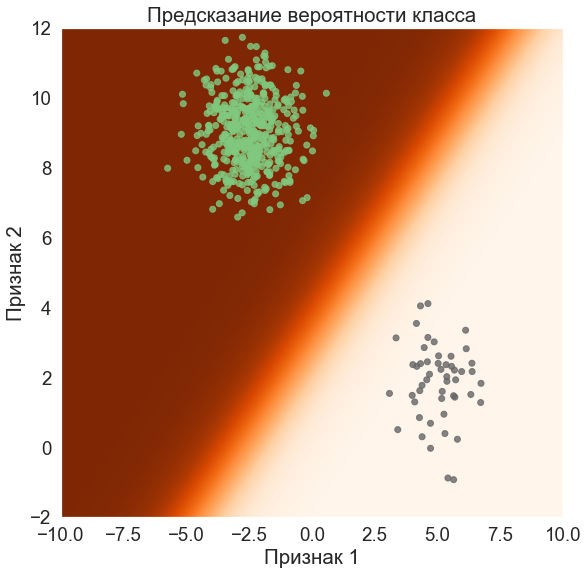

In [ ]:
plt.figure(figsize=(9, 9))
plt.pcolormesh(x0_grid, x1_grid, prob_grid, cmap='Oranges')
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, cmap='Accent')
plt.xlim((-10, 10)), plt.ylim((-2, 12))
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.title('Предсказание вероятности класса');

Видим, что классы разделены правильно. Вопреки теории здесь не возникло переобучения, при котором оценка вероятностей всех классов будет $0$ или $1$. Причина в том, что по умолчанию используется регуляризация, управлять которой можно с помощью параметра `C`.